# **SENARYO A**



## Imports

In [40]:
import pandas as pd
from pyomo.environ import *
from pyomo.opt import SolverFactory
import matplotlib.pyplot as plt

In [41]:
!apt-get install -y coinor-cbc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
coinor-cbc is already the newest version (2.10.7+ds1-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [42]:
!apt-get install -y glpk-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
glpk-utils is already the newest version (5.0-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


## Data

In [43]:
# Purpose: Load data from a CSV file, combine date and time into a datetime column, sort by datetime, and create a sequential hourly index.
data_path = 'data.csv'
df = pd.read_csv(data_path)  # Read the CSV data file
df['Datetime'] = pd.to_datetime(df['Tarih'] + ' ' + df['Saat'], dayfirst=True)  # Combine 'Tarih' and 'Saat' columns into datetime
df = df.sort_values('Datetime').reset_index(drop=True)  # Sort data by datetime and reset index
df['t'] = range(len(df))  # Create an hourly index as a sequential integer series

# Result: DataFrame sorted by datetime with a new datetime column and a sequential hourly index for time series analysis.


In [44]:
df

,Tarih,Saat,Fiyat_(TL/MWh),PV_Üretim_Tahmini_(MWh),Datetime,t
0,01.05.2025,00:00,1499,0.0,2025-05-01 00:00:00,0
1,01.05.2025,01:00,1575,0.0,2025-05-01 01:00:00,1
2,01.05.2025,02:00,1400,0.0,2025-05-01 02:00:00,2
3,01.05.2025,03:00,1400,0.0,2025-05-01 03:00:00,3
4,01.05.2025,04:00,1400,0.7,2025-05-01 04:00:00,4
...,...,...,...,...,...,...
739,31.05.2025,19:00,3390,0.5,2025-05-31 19:00:00,739
740,31.05.2025,20:00,3400,0.0,2025-05-31 20:00:00,740
741,31.05.2025,21:00,3400,0.0,2025-05-31 21:00:00,741
742,31.05.2025,22:00,3080,0.0,2025-05-31 22:00:00,742


## Pyomo Model

### Parameters and Set

In [45]:
# Purpose: Define a Pyomo optimization model with a time index, and initialize price and PV production parameters from the data.
model = ConcreteModel()

T = len(df)
model.T = RangeSet(0, T - 1)  # Time set from 0 to T-1 (744 hours)

price_dict = df.set_index('t')['Fiyat_(TL/MWh)'].to_dict()
model.price = Param(model.T, initialize=price_dict)  # Price parameter (TL/MWh)
pv_dict = df.set_index('t')['PV_Üretim_Tahmini_(MWh)'].to_dict()
model.pv_production = Param(model.T, initialize=pv_dict)  # PV production forecast parameter (MWh)

# Result: Pyomo model with indexed parameters for price and PV production ready for further optimization formulation.


### Variables

In [46]:
# Purpose: Define the decision variable representing energy fed from PV to the grid at each time period (MWh).
model.pv_to_grid = Var(model.T, domain=NonNegativeReals)  # Non-negative real variable for PV energy sent to grid

# Result: Decision variable 'pv_to_grid' added to the model for optimization of energy flow from PV to grid.

### Constraints

In [47]:
# Purpose: Define constraints to ensure PV energy sent to grid equals PV production and does not exceed grid capacity.

def pv_flow_rule(model, t):
    return model.pv_to_grid[t] == model.pv_production[t]  # PV to grid equals PV production

model.pv_production_constraint = Constraint(model.T, rule=pv_flow_rule)

grid_capacity = 8  # MW
def grid_capacity_rule(model, t):
    return model.pv_to_grid[t] <= grid_capacity  # Limit PV feed-in to grid capacity

model.grid_capacity_constraint = Constraint(model.T, rule=grid_capacity_rule)

# Result: Constraints enforce exact PV production feed-in and respect grid capacity limits at each time period.


### Objective

In [48]:
# Purpose: Maximize total revenue obtained from selling PV production to the grid.

def objective_rule(model):
    return sum(model.pv_to_grid[t] * model.price[t] for t in model.T)  # Total revenue from PV energy sales

model.objective = Objective(rule=objective_rule, sense=maximize)

# Result: Objective function set to maximize the total income from PV energy fed into the grid.


## Solver

In [49]:
# Purpose: Define and run a solver to solve the Pyomo model, then check and report the solution status.

solver = SolverFactory('glpk')  # Use an installed solver ('glpk', 'cbc', 'gurobi', etc.)

results = solver.solve(model, tee=True)  # Solve the model with solver output shown

# Check solution status and print appropriate message
if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
    print("Model solved successfully")
elif results.solver.termination_condition == TerminationCondition.infeasible:
    print("No feasible solution found – infeasible!")
else:
    print(f"Warning: Solution status: {results.solver.status}, Reason: {results.solver.termination_condition}")

# Result: Model solution attempted and status printed to inform success, infeasibility, or other conditions.


GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /tmp/tmp6s2vx53w.glpk.raw --wglp /tmp/tmpq42jh2_i.glpk.glp --cpxlp
 /tmp/tmpmwyurei7.pyomo.lp
Reading problem data from '/tmp/tmpmwyurei7.pyomo.lp'...
1488 rows, 744 columns, 1488 non-zeros
7449 lines were read
Writing problem data to '/tmp/tmpq42jh2_i.glpk.glp'...
5692 lines were written
GLPK Simplex Optimizer 5.0
1488 rows, 744 columns, 1488 non-zeros
Preprocessing...
~     0: obj =   2.019824900e+06  infeas =  0.000e+00
OPTIMAL SOLUTION FOUND BY LP PREPROCESSOR
Time used:   0.0 secs
Memory used: 0.8 Mb (794100 bytes)
Writing basic solution to '/tmp/tmp6s2vx53w.glpk.raw'...
2241 lines were written
Model solved successfully


## Results

In [50]:
# Purpose: Extract hourly solution values into DataFrame, calculate total financial revenue and total PV energy fed to the grid.

df['PV_to_Grid_(MWh)'] = df['t'].apply(lambda t: model.pv_to_grid[t]())  # Get optimized PV to grid energy per hour
df['Gelir_(TL)'] = df['PV_to_Grid_(MWh)'] * df['Fiyat_(TL/MWh)']  # Calculate hourly revenue

total_revenue = df['Gelir_(TL)'].sum()
print(f"Total Financial Revenue (Scenario A): {total_revenue:,.2f} TL")

total_energy = df['PV_to_Grid_(MWh)'].sum()
print(f"Total PV → Grid Energy: {total_energy:,.2f} MWh")

# Result: DataFrame updated with solution and revenues; total revenue and energy values printed.


Total Financial Revenue (Scenario A): 2,019,824.90 TL
Total PV → Grid Energy: 1,089.40 MWh


In [51]:
df.head(24)

,Tarih,Saat,Fiyat_(TL/MWh),PV_Üretim_Tahmini_(MWh),Datetime,t,PV_to_Grid_(MWh),Gelir_(TL)
0,01.05.2025,00:00,1499,0.0,2025-05-01 00:00:00,0,0.0,0.0
1,01.05.2025,01:00,1575,0.0,2025-05-01 01:00:00,1,0.0,0.0
2,01.05.2025,02:00,1400,0.0,2025-05-01 02:00:00,2,0.0,0.0
3,01.05.2025,03:00,1400,0.0,2025-05-01 03:00:00,3,0.0,0.0
4,01.05.2025,04:00,1400,0.7,2025-05-01 04:00:00,4,0.7,980.0
5,01.05.2025,05:00,1400,1.7,2025-05-01 05:00:00,5,1.7,2380.0
6,01.05.2025,06:00,1362,2.0,2025-05-01 06:00:00,6,2.0,2724.0
7,01.05.2025,07:00,1042,3.8,2025-05-01 07:00:00,7,3.8,3959.6
8,01.05.2025,08:00,1499,3.7,2025-05-01 08:00:00,8,3.7,5546.3
9,01.05.2025,09:00,1499,4.9,2025-05-01 09:00:00,9,4.9,7345.1


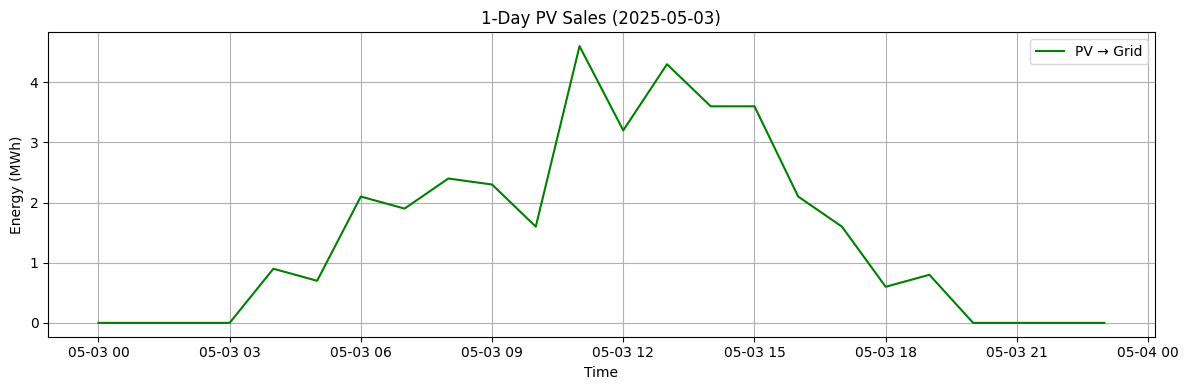

In [52]:
# Purpose: Filter data for a specific day and plot hourly PV energy fed to the grid for that day.

bir_gun = df[(df['Datetime'] >= '2025-05-03') & (df['Datetime'] < '2025-05-04')]  # Filter data for one day

plt.figure(figsize=(12,4))
plt.plot(bir_gun['Datetime'], bir_gun['PV_to_Grid_(MWh)'], label='PV → Grid', color='green')  # Plot PV energy to grid
plt.title("1-Day PV Sales (2025-05-03)")
plt.ylabel("Energy (MWh)")
plt.xlabel("Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Result: Visualization of hourly PV energy supplied to the grid over the selected day.
